In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from torchsummary import summary
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
# Hyperparameters
batch_size = 256
img_size = 28 # original image size is 28x28
channels = 1 # grayscale image
latent_dim = 2
num_epochs = 500 # training epochs

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

dataset = datasets.MNIST(
    root="./data", # Data storage directory
    train=True,
    transform=transform,
    download=True,
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]


In [5]:
# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


Training samples: 48000, Validation samples: 12000


In [6]:
# Define the Variational Autoencoder (VAE) in PyTorch
class VAE(nn.Module):
    def __init__(self, channels, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)

        self.flatten_dim = 64 * 7 * 7
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.flatten_dim)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_final = nn.Conv2d(16, channels, kernel_size=3, padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.flatten_dim)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.fc_decode(z))
        x = x.view(-1, 64, 7, 7)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.conv_final(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [7]:
def loss_function(recon_x, x, mu, log_var, B=1000):
    # Flatten tensors for MSE calculation
    recon_x_flat = recon_x.view(recon_x.size(0), -1)
    x_flat = x.view(x.size(0), -1)

    # Calculate MSE (per element average)
    mse_out = F.mse_loss(recon_x_flat, x_flat, reduction='mean')

    # Scale by input dimensions
    reconstruction_loss = mse_out * x.shape[1] * x.shape[2] * x.shape[3]

    # Calculate KL divergence
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), axis=1)

    # Compute final loss (adding B*recon_loss + kl_loss)
    total_loss = B * reconstruction_loss + torch.mean(kl_loss)

    return total_loss, reconstruction_loss, torch.mean(kl_loss)


In [8]:
# Create model, optimizer, etc.
model = VAE(channels, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


In [9]:
import os
from datetime import datetime

# Create a log directory if it doesn't exist
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Create a log file with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = os.path.join(log_dir, f"training_log_{timestamp}.txt")

# Open the log file
with open(log_file, "w") as f:
    f.write(f"Training started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model: VAE with latent_dim={latent_dim}\n")
    f.write(f"Batch size: {batch_size}, Image size: {img_size}x{img_size}\n")
    f.write(f"Total epochs: {num_epochs}\n\n")
    f.write("Epoch,Avg_Loss,Recon_Loss,KL_Loss\n")

# Training loop with logging
model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    epoch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for data, _ in epoch_bar:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        epoch_bar.set_postfix(loss=loss.item())

    # Calculate average loss
    avg_loss = train_loss / len(train_loader.dataset)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} Loss per sample: {avg_loss:.4f} "
          f"Recon Loss: {recon_loss.item():.4f} KL Loss: {kl_loss.item():.4f}")

    # Save to log file
    with open(log_file, "a") as f:
        f.write(f"{epoch+1},{avg_loss:.6f},{recon_loss.item():.6f},{kl_loss.item():.6f}\n")

# Log training completion
with open(log_file, "a") as f:
    f.write(f"\nTraining completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

print(f"Training log saved to {log_file}")


Epoch 1/500 Loss per sample: 251.0385 Recon Loss: 49.5466 KL Loss: 53.3951


Epoch 2/500 Loss per sample: 177.3092 Recon Loss: 41.8810 KL Loss: 48.6906


Epoch 3/500 Loss per sample: 165.0492 Recon Loss: 41.9562 KL Loss: 32.0880


Epoch 4/500 Loss per sample: 157.6199 Recon Loss: 39.1014 KL Loss: 27.1779


Epoch 5/500 Loss per sample: 151.5477 Recon Loss: 37.6807 KL Loss: 26.2838


Epoch 6/500 Loss per sample: 147.5924 Recon Loss: 38.3279 KL Loss: 22.9610


Epoch 7/500 Loss per sample: 144.6530 Recon Loss: 35.1869 KL Loss: 23.0153


Epoch 8/500 Loss per sample: 142.2010 Recon Loss: 38.2590 KL Loss: 22.0056


Epoch 9/500 Loss per sample: 140.0883 Recon Loss: 34.4422 KL Loss: 23.5784


Epoch 10/500 Loss per sample: 138.5647 Recon Loss: 33.9156 KL Loss: 22.4974


Epoch 11/500 Loss per sample: 137.3140 Recon Loss: 35.1252 KL Loss: 23.2996


Epoch 12/500 Loss per sample: 136.2646 Recon Loss: 36.1227 KL Loss: 21.8856


Epoch 13/500 Loss per sample: 135.3452 Recon Loss: 35.1398 KL Loss: 21.8503


Epoch 14/500 Loss per sample: 134.7130 Recon Loss: 34.4650 KL Loss: 21.0020


Epoch 15/500 Loss per sample: 133.8821 Recon Loss: 37.0539 KL Loss: 19.5868


Epoch 16/500 Loss per sample: 133.2748 Recon Loss: 33.8143 KL Loss: 21.1782


Epoch 17/500 Loss per sample: 132.5067 Recon Loss: 33.3292 KL Loss: 21.3364


Epoch 18/500 Loss per sample: 132.0635 Recon Loss: 35.2915 KL Loss: 20.5950


Epoch 19/500 Loss per sample: 131.3914 Recon Loss: 32.1951 KL Loss: 20.1210


Epoch 20/500 Loss per sample: 130.9682 Recon Loss: 36.3118 KL Loss: 19.0665


Epoch 21/500 Loss per sample: 130.4595 Recon Loss: 33.6335 KL Loss: 20.2450


Epoch 22/500 Loss per sample: 130.1128 Recon Loss: 37.3502 KL Loss: 19.1140


Epoch 23/500 Loss per sample: 129.5769 Recon Loss: 34.3556 KL Loss: 20.6295


Epoch 24/500 Loss per sample: 129.2021 Recon Loss: 32.5977 KL Loss: 21.0408


Epoch 25/500 Loss per sample: 128.6195 Recon Loss: 30.7374 KL Loss: 21.1042


Epoch 26/500 Loss per sample: 128.2425 Recon Loss: 33.9590 KL Loss: 20.3169


Epoch 27/500 Loss per sample: 128.0058 Recon Loss: 34.3457 KL Loss: 18.6009


Epoch 28/500 Loss per sample: 127.8236 Recon Loss: 33.5439 KL Loss: 20.1258


Epoch 29/500 Loss per sample: 127.3375 Recon Loss: 33.7611 KL Loss: 18.7708


Epoch 30/500 Loss per sample: 126.9379 Recon Loss: 30.0305 KL Loss: 20.7937


Epoch 31/500 Loss per sample: 126.7747 Recon Loss: 31.9597 KL Loss: 21.5546


Epoch 32/500 Loss per sample: 126.5989 Recon Loss: 33.7937 KL Loss: 17.0296


Epoch 33/500 Loss per sample: 126.2532 Recon Loss: 31.4275 KL Loss: 22.3658


Epoch 34/500 Loss per sample: 125.8027 Recon Loss: 30.0894 KL Loss: 20.5223


Epoch 35/500 Loss per sample: 125.5400 Recon Loss: 31.6488 KL Loss: 18.7167


Epoch 36/500 Loss per sample: 125.3456 Recon Loss: 33.1253 KL Loss: 19.6941


Epoch 37/500 Loss per sample: 125.0841 Recon Loss: 31.4615 KL Loss: 19.7875


Epoch 38/500 Loss per sample: 124.9083 Recon Loss: 31.6492 KL Loss: 19.9718


Epoch 39/500 Loss per sample: 124.6663 Recon Loss: 32.4736 KL Loss: 19.2094


Epoch 40/500 Loss per sample: 124.3346 Recon Loss: 33.0020 KL Loss: 20.0871


Epoch 41/500 Loss per sample: 124.3656 Recon Loss: 32.3081 KL Loss: 20.0050


Epoch 42/500 Loss per sample: 124.0701 Recon Loss: 29.9232 KL Loss: 20.7715


Epoch 43/500 Loss per sample: 123.6167 Recon Loss: 30.9648 KL Loss: 20.2715


Epoch 44/500 Loss per sample: 123.5777 Recon Loss: 31.7769 KL Loss: 20.6325


Epoch 45/500 Loss per sample: 123.6014 Recon Loss: 29.9329 KL Loss: 19.5924


Epoch 46/500 Loss per sample: 123.3544 Recon Loss: 31.4539 KL Loss: 18.8809


Epoch 47/500 Loss per sample: 123.0799 Recon Loss: 30.4372 KL Loss: 21.4452


Epoch 48/500 Loss per sample: 122.8368 Recon Loss: 30.0538 KL Loss: 21.8379


Epoch 49/500 Loss per sample: 122.6702 Recon Loss: 32.0467 KL Loss: 19.5693


Epoch 50/500 Loss per sample: 122.5425 Recon Loss: 32.9227 KL Loss: 19.7574


Epoch 51/500 Loss per sample: 122.3949 Recon Loss: 30.8439 KL Loss: 20.3358


Epoch 52/500 Loss per sample: 122.4043 Recon Loss: 30.7180 KL Loss: 23.9095


Epoch 53/500 Loss per sample: 122.2208 Recon Loss: 31.2509 KL Loss: 19.5400


Epoch 54/500 Loss per sample: 121.7981 Recon Loss: 30.7128 KL Loss: 19.4476


Epoch 55/500 Loss per sample: 121.8438 Recon Loss: 29.6531 KL Loss: 20.4340


Epoch 56/500 Loss per sample: 121.5460 Recon Loss: 32.8939 KL Loss: 19.7100


Epoch 57/500 Loss per sample: 121.3837 Recon Loss: 30.5906 KL Loss: 21.1710


Epoch 58/500 Loss per sample: 121.3686 Recon Loss: 33.9249 KL Loss: 18.3065


Epoch 59/500 Loss per sample: 121.3463 Recon Loss: 29.4784 KL Loss: 21.6049


Epoch 60/500 Loss per sample: 121.0844 Recon Loss: 32.7126 KL Loss: 18.9588


Epoch 61/500 Loss per sample: 120.8732 Recon Loss: 30.0010 KL Loss: 21.9455


Epoch 62/500 Loss per sample: 120.6105 Recon Loss: 29.7092 KL Loss: 19.3362


Epoch 63/500 Loss per sample: 120.6750 Recon Loss: 32.5790 KL Loss: 18.9981


Epoch 64/500 Loss per sample: 120.8799 Recon Loss: 31.4338 KL Loss: 18.6612


Epoch 65/500 Loss per sample: 120.4352 Recon Loss: 31.4916 KL Loss: 19.0673


Epoch 66/500 Loss per sample: 120.3542 Recon Loss: 30.1414 KL Loss: 19.6220


Epoch 67/500 Loss per sample: 120.2308 Recon Loss: 28.4402 KL Loss: 20.6091


Epoch 68/500 Loss per sample: 120.0193 Recon Loss: 28.0846 KL Loss: 20.7816


Epoch 69/500 Loss per sample: 119.9637 Recon Loss: 32.7919 KL Loss: 20.3556


Epoch 70/500 Loss per sample: 119.8512 Recon Loss: 28.2032 KL Loss: 20.3651


Epoch 71/500 Loss per sample: 119.8403 Recon Loss: 30.9185 KL Loss: 19.8418


Epoch 72/500 Loss per sample: 119.7109 Recon Loss: 30.8787 KL Loss: 19.7160


Epoch 73/500 Loss per sample: 119.6213 Recon Loss: 31.1688 KL Loss: 19.6294


Epoch 74/500 Loss per sample: 119.4280 Recon Loss: 31.5794 KL Loss: 19.4132


Epoch 75/500 Loss per sample: 119.4028 Recon Loss: 31.0277 KL Loss: 20.7417


Epoch 76/500 Loss per sample: 119.4159 Recon Loss: 31.3306 KL Loss: 18.9490


Epoch 77/500 Loss per sample: 119.3986 Recon Loss: 31.6537 KL Loss: 19.5261


Epoch 78/500 Loss per sample: 119.1265 Recon Loss: 30.5314 KL Loss: 17.6394


Epoch 79/500 Loss per sample: 119.1109 Recon Loss: 31.9944 KL Loss: 19.1152


Epoch 80/500 Loss per sample: 119.0086 Recon Loss: 28.8604 KL Loss: 20.6340


Epoch 81/500 Loss per sample: 118.8151 Recon Loss: 29.5364 KL Loss: 21.5050


Epoch 82/500 Loss per sample: 118.6479 Recon Loss: 31.0131 KL Loss: 20.0599


Epoch 83/500 Loss per sample: 118.8110 Recon Loss: 28.5789 KL Loss: 20.6366


Epoch 84/500 Loss per sample: 118.8110 Recon Loss: 31.1029 KL Loss: 21.1209


Epoch 85/500 Loss per sample: 118.5491 Recon Loss: 31.0493 KL Loss: 20.8916


Epoch 86/500 Loss per sample: 118.3518 Recon Loss: 32.4610 KL Loss: 18.8087


Epoch 87/500 Loss per sample: 118.3849 Recon Loss: 31.4910 KL Loss: 20.8614


Epoch 88/500 Loss per sample: 118.2388 Recon Loss: 30.9203 KL Loss: 20.7516


Epoch 89/500 Loss per sample: 118.3240 Recon Loss: 30.1667 KL Loss: 18.6698


Epoch 90/500 Loss per sample: 118.4013 Recon Loss: 31.7182 KL Loss: 20.5902


Epoch 91/500 Loss per sample: 117.9158 Recon Loss: 30.7660 KL Loss: 19.9832


Epoch 92/500 Loss per sample: 117.8880 Recon Loss: 27.4309 KL Loss: 21.5700


Epoch 93/500 Loss per sample: 117.9449 Recon Loss: 30.7612 KL Loss: 21.2606


Epoch 94/500 Loss per sample: 117.9342 Recon Loss: 31.8291 KL Loss: 19.2169


Epoch 95/500 Loss per sample: 117.7486 Recon Loss: 30.3184 KL Loss: 18.2057


Epoch 96/500 Loss per sample: 118.0509 Recon Loss: 27.9459 KL Loss: 21.8246


Epoch 97/500 Loss per sample: 117.7922 Recon Loss: 31.6056 KL Loss: 19.9361


Epoch 98/500 Loss per sample: 117.6314 Recon Loss: 30.3488 KL Loss: 22.5233


Epoch 99/500 Loss per sample: 117.5506 Recon Loss: 29.2022 KL Loss: 18.5163


Epoch 100/500 Loss per sample: 117.4276 Recon Loss: 30.8266 KL Loss: 19.1344


Epoch 101/500 Loss per sample: 117.5287 Recon Loss: 31.5580 KL Loss: 21.8518


Epoch 102/500 Loss per sample: 117.3138 Recon Loss: 30.5187 KL Loss: 20.0722


Epoch 103/500 Loss per sample: 117.2898 Recon Loss: 31.2362 KL Loss: 21.0589


Epoch 104/500 Loss per sample: 117.0576 Recon Loss: 28.0007 KL Loss: 21.5877


Epoch 105/500 Loss per sample: 117.1028 Recon Loss: 31.1667 KL Loss: 20.8461


Epoch 106/500 Loss per sample: 117.1144 Recon Loss: 30.7896 KL Loss: 21.3313


Epoch 107/500 Loss per sample: 117.1229 Recon Loss: 29.5470 KL Loss: 19.7162


Epoch 108/500 Loss per sample: 117.0254 Recon Loss: 29.3285 KL Loss: 19.0290


Epoch 109/500 Loss per sample: 116.9119 Recon Loss: 30.5845 KL Loss: 23.1756


Epoch 110/500 Loss per sample: 116.8222 Recon Loss: 28.5166 KL Loss: 20.5093


Epoch 111/500 Loss per sample: 116.7638 Recon Loss: 27.7990 KL Loss: 21.7947


Epoch 112/500 Loss per sample: 116.8761 Recon Loss: 29.7890 KL Loss: 21.2522


Epoch 113/500 Loss per sample: 116.7181 Recon Loss: 27.3156 KL Loss: 22.5093


Epoch 114/500 Loss per sample: 116.5739 Recon Loss: 29.1602 KL Loss: 20.8938


Epoch 115/500 Loss per sample: 116.7366 Recon Loss: 29.3690 KL Loss: 20.9555


Epoch 116/500 Loss per sample: 116.5110 Recon Loss: 30.0219 KL Loss: 22.1494


Epoch 117/500 Loss per sample: 116.4404 Recon Loss: 28.0213 KL Loss: 23.6257


Epoch 118/500 Loss per sample: 116.4337 Recon Loss: 28.8701 KL Loss: 20.0765


Epoch 119/500 Loss per sample: 116.4825 Recon Loss: 29.2419 KL Loss: 21.0218


Epoch 120/500 Loss per sample: 116.3679 Recon Loss: 28.8485 KL Loss: 20.0214


Epoch 121/500 Loss per sample: 116.2762 Recon Loss: 30.1388 KL Loss: 17.7732


Epoch 122/500 Loss per sample: 116.3833 Recon Loss: 29.8862 KL Loss: 22.0544


Epoch 123/500 Loss per sample: 116.1368 Recon Loss: 27.5414 KL Loss: 24.2550


Epoch 124/500 Loss per sample: 116.0749 Recon Loss: 29.6144 KL Loss: 20.2869


Epoch 125/500 Loss per sample: 116.2202 Recon Loss: 30.1242 KL Loss: 20.5655


Epoch 126/500 Loss per sample: 115.9824 Recon Loss: 30.0849 KL Loss: 20.0769


Epoch 127/500 Loss per sample: 116.0725 Recon Loss: 29.4930 KL Loss: 20.1407


Epoch 128/500 Loss per sample: 115.9988 Recon Loss: 30.6958 KL Loss: 19.3153


Epoch 129/500 Loss per sample: 115.9382 Recon Loss: 28.2860 KL Loss: 21.3813


Epoch 130/500 Loss per sample: 116.0071 Recon Loss: 28.7735 KL Loss: 20.0616


Epoch 131/500 Loss per sample: 115.8430 Recon Loss: 29.1887 KL Loss: 20.7548


Epoch 132/500 Loss per sample: 115.6909 Recon Loss: 29.2761 KL Loss: 20.7703


Epoch 133/500 Loss per sample: 115.7788 Recon Loss: 28.9963 KL Loss: 21.4021


Epoch 134/500 Loss per sample: 115.8595 Recon Loss: 28.3977 KL Loss: 19.7785


Epoch 135/500 Loss per sample: 115.7174 Recon Loss: 28.3361 KL Loss: 21.3744


Epoch 136/500 Loss per sample: 115.5778 Recon Loss: 27.4407 KL Loss: 21.7505


Epoch 137/500 Loss per sample: 115.5765 Recon Loss: 29.6432 KL Loss: 20.6848


Epoch 138/500 Loss per sample: 115.6361 Recon Loss: 29.9302 KL Loss: 19.5927


Epoch 139/500 Loss per sample: 115.5395 Recon Loss: 28.3903 KL Loss: 21.0364


Epoch 140/500 Loss per sample: 115.4921 Recon Loss: 28.6941 KL Loss: 20.8054


Epoch 141/500 Loss per sample: 115.5981 Recon Loss: 29.8682 KL Loss: 20.2615


Epoch 142/500 Loss per sample: 115.4160 Recon Loss: 28.0582 KL Loss: 23.2441


Epoch 143/500 Loss per sample: 115.3107 Recon Loss: 30.0047 KL Loss: 21.6749


Epoch 144/500 Loss per sample: 115.4917 Recon Loss: 28.2011 KL Loss: 23.1259


Epoch 145/500 Loss per sample: 115.2608 Recon Loss: 28.5885 KL Loss: 21.5109


Epoch 146/500 Loss per sample: 115.2939 Recon Loss: 28.2336 KL Loss: 21.1653


Epoch 147/500 Loss per sample: 115.1759 Recon Loss: 28.2065 KL Loss: 22.4824


Epoch 148/500 Loss per sample: 115.2577 Recon Loss: 31.2369 KL Loss: 19.7909


Epoch 149/500 Loss per sample: 115.1298 Recon Loss: 30.1269 KL Loss: 21.9433


Epoch 150/500 Loss per sample: 115.1188 Recon Loss: 32.2004 KL Loss: 21.5808


Epoch 151/500 Loss per sample: 115.0221 Recon Loss: 30.2561 KL Loss: 22.0425


Epoch 152/500 Loss per sample: 115.1017 Recon Loss: 27.4388 KL Loss: 21.1215


Epoch 153/500 Loss per sample: 115.1040 Recon Loss: 28.1034 KL Loss: 23.2252


Epoch 154/500 Loss per sample: 114.9472 Recon Loss: 31.2372 KL Loss: 19.4776


Epoch 155/500 Loss per sample: 114.9694 Recon Loss: 28.9907 KL Loss: 21.8246


Epoch 156/500 Loss per sample: 114.8551 Recon Loss: 29.2392 KL Loss: 22.5908


Epoch 157/500 Loss per sample: 114.9188 Recon Loss: 29.1998 KL Loss: 21.5879


Epoch 158/500 Loss per sample: 114.8720 Recon Loss: 28.8952 KL Loss: 19.5639


Epoch 159/500 Loss per sample: 114.8456 Recon Loss: 29.7004 KL Loss: 21.6684


Epoch 160/500 Loss per sample: 114.6939 Recon Loss: 29.2667 KL Loss: 21.6156


Epoch 161/500 Loss per sample: 114.7442 Recon Loss: 29.1618 KL Loss: 20.3276


Epoch 162/500 Loss per sample: 114.5883 Recon Loss: 28.5532 KL Loss: 21.7169


Epoch 163/500 Loss per sample: 114.5636 Recon Loss: 29.9607 KL Loss: 21.3575


Epoch 164/500 Loss per sample: 114.6860 Recon Loss: 29.7877 KL Loss: 20.4709


Epoch 165/500 Loss per sample: 114.8483 Recon Loss: 29.5710 KL Loss: 20.9007


Epoch 166/500 Loss per sample: 114.4528 Recon Loss: 31.2969 KL Loss: 18.7828


Epoch 167/500 Loss per sample: 114.5536 Recon Loss: 26.9442 KL Loss: 20.4869


Epoch 168/500 Loss per sample: 114.6499 Recon Loss: 29.2426 KL Loss: 23.4611


Epoch 169/500 Loss per sample: 114.5946 Recon Loss: 31.3567 KL Loss: 19.9737


Epoch 170/500 Loss per sample: 114.5903 Recon Loss: 30.3047 KL Loss: 21.9734


Epoch 171/500 Loss per sample: 114.4483 Recon Loss: 28.8860 KL Loss: 22.1529


Epoch 172/500 Loss per sample: 114.3935 Recon Loss: 29.5825 KL Loss: 22.2028


Epoch 173/500 Loss per sample: 114.5287 Recon Loss: 29.7001 KL Loss: 22.5527


Epoch 174/500 Loss per sample: 114.3214 Recon Loss: 30.0179 KL Loss: 22.6294


Epoch 175/500 Loss per sample: 114.2403 Recon Loss: 28.3170 KL Loss: 22.2557


Epoch 176/500 Loss per sample: 114.1873 Recon Loss: 30.2744 KL Loss: 20.9851


Epoch 177/500 Loss per sample: 114.3941 Recon Loss: 30.4027 KL Loss: 21.5174


Epoch 178/500 Loss per sample: 114.1194 Recon Loss: 25.9742 KL Loss: 21.5645


Epoch 179/500 Loss per sample: 114.2493 Recon Loss: 27.9660 KL Loss: 23.2484


Epoch 180/500 Loss per sample: 114.2755 Recon Loss: 30.4374 KL Loss: 20.1886


Epoch 181/500 Loss per sample: 114.1460 Recon Loss: 28.4866 KL Loss: 24.6085


Epoch 182/500 Loss per sample: 114.0588 Recon Loss: 29.7172 KL Loss: 21.6635


Epoch 183/500 Loss per sample: 114.3212 Recon Loss: 33.2079 KL Loss: 23.0801


Epoch 184/500 Loss per sample: 114.0901 Recon Loss: 28.9520 KL Loss: 20.4608


Epoch 185/500 Loss per sample: 114.1698 Recon Loss: 28.4369 KL Loss: 19.2925


Epoch 186/500 Loss per sample: 114.0226 Recon Loss: 30.0293 KL Loss: 20.9176


Epoch 187/500 Loss per sample: 113.9472 Recon Loss: 28.7594 KL Loss: 23.1870


Epoch 188/500 Loss per sample: 113.9391 Recon Loss: 29.5888 KL Loss: 19.5206


Epoch 189/500 Loss per sample: 113.9313 Recon Loss: 30.1898 KL Loss: 20.8664


Epoch 190/500 Loss per sample: 113.9369 Recon Loss: 29.0312 KL Loss: 22.4308


Epoch 191/500 Loss per sample: 113.9571 Recon Loss: 29.4750 KL Loss: 25.2161


Epoch 192/500 Loss per sample: 113.9762 Recon Loss: 31.6460 KL Loss: 20.4162


Epoch 193/500 Loss per sample: 113.8881 Recon Loss: 28.7543 KL Loss: 22.8969


Epoch 194/500 Loss per sample: 113.8080 Recon Loss: 28.6335 KL Loss: 22.9872


Epoch 195/500 Loss per sample: 113.7873 Recon Loss: 29.2211 KL Loss: 23.4076


Epoch 196/500 Loss per sample: 113.9090 Recon Loss: 26.1110 KL Loss: 25.0792


Epoch 197/500 Loss per sample: 113.7456 Recon Loss: 31.7458 KL Loss: 21.0017


Epoch 198/500 Loss per sample: 113.7308 Recon Loss: 28.9517 KL Loss: 24.1341


Epoch 199/500 Loss per sample: 113.9041 Recon Loss: 30.6077 KL Loss: 21.8834


Epoch 200/500 Loss per sample: 113.7479 Recon Loss: 30.0919 KL Loss: 21.8467


Epoch 201/500 Loss per sample: 113.6709 Recon Loss: 29.1547 KL Loss: 22.1437


Epoch 202/500 Loss per sample: 113.8098 Recon Loss: 28.5459 KL Loss: 22.3922


Epoch 203/500 Loss per sample: 113.6668 Recon Loss: 29.9463 KL Loss: 22.4287


Epoch 204/500 Loss per sample: 113.5587 Recon Loss: 28.3189 KL Loss: 22.6949


Epoch 205/500 Loss per sample: 113.6304 Recon Loss: 29.0736 KL Loss: 23.8224


Epoch 206/500 Loss per sample: 113.5159 Recon Loss: 29.8500 KL Loss: 21.9051


Epoch 207/500 Loss per sample: 113.5222 Recon Loss: 28.7127 KL Loss: 19.8272


Epoch 208/500 Loss per sample: 113.5939 Recon Loss: 30.3916 KL Loss: 22.5773


Epoch 209/500 Loss per sample: 113.6618 Recon Loss: 28.8478 KL Loss: 22.6534


Epoch 210/500 Loss per sample: 113.4573 Recon Loss: 27.9170 KL Loss: 20.0052


Epoch 211/500 Loss per sample: 113.3723 Recon Loss: 27.4187 KL Loss: 24.9128


Epoch 212/500 Loss per sample: 113.3386 Recon Loss: 30.2438 KL Loss: 21.2670


Epoch 213/500 Loss per sample: 113.5210 Recon Loss: 28.0897 KL Loss: 26.3676


Epoch 214/500 Loss per sample: 113.4261 Recon Loss: 27.1606 KL Loss: 24.5466


Epoch 215/500 Loss per sample: 113.4163 Recon Loss: 28.1948 KL Loss: 23.1936


Epoch 216/500 Loss per sample: 113.4380 Recon Loss: 29.3558 KL Loss: 20.1687


Epoch 217/500 Loss per sample: 113.3522 Recon Loss: 28.3307 KL Loss: 23.7226


Epoch 218/500 Loss per sample: 113.1548 Recon Loss: 28.2790 KL Loss: 20.7363


Epoch 219/500 Loss per sample: 113.3785 Recon Loss: 29.7292 KL Loss: 20.4546


Epoch 220/500 Loss per sample: 113.1985 Recon Loss: 28.6237 KL Loss: 22.7398


Epoch 221/500 Loss per sample: 113.2808 Recon Loss: 28.3111 KL Loss: 20.9291


Epoch 222/500 Loss per sample: 113.3633 Recon Loss: 29.8912 KL Loss: 25.8036


Epoch 223/500 Loss per sample: 113.2493 Recon Loss: 30.9385 KL Loss: 23.6387


Epoch 224/500 Loss per sample: 113.1946 Recon Loss: 28.4914 KL Loss: 22.2016


Epoch 225/500 Loss per sample: 113.3442 Recon Loss: 30.0353 KL Loss: 21.1192


Epoch 226/500 Loss per sample: 113.2408 Recon Loss: 27.6870 KL Loss: 21.9551


Epoch 227/500 Loss per sample: 113.0623 Recon Loss: 28.7959 KL Loss: 21.7693


Epoch 228/500 Loss per sample: 113.1479 Recon Loss: 29.9443 KL Loss: 22.0385


Epoch 229/500 Loss per sample: 113.1938 Recon Loss: 29.3679 KL Loss: 20.5005


Epoch 230/500 Loss per sample: 113.0816 Recon Loss: 29.0785 KL Loss: 21.8810


Epoch 231/500 Loss per sample: 112.9777 Recon Loss: 30.3147 KL Loss: 22.9001


Epoch 232/500 Loss per sample: 113.1878 Recon Loss: 26.8921 KL Loss: 22.0315


Epoch 233/500 Loss per sample: 113.1216 Recon Loss: 29.2174 KL Loss: 20.8907


Epoch 234/500 Loss per sample: 113.0789 Recon Loss: 27.6046 KL Loss: 24.1868


Epoch 235/500 Loss per sample: 113.0431 Recon Loss: 30.4973 KL Loss: 21.6020


Epoch 236/500 Loss per sample: 112.9231 Recon Loss: 28.3822 KL Loss: 20.8891


Epoch 237/500 Loss per sample: 113.0173 Recon Loss: 29.4197 KL Loss: 21.6654


Epoch 238/500 Loss per sample: 113.0155 Recon Loss: 30.2209 KL Loss: 21.0831


Epoch 239/500 Loss per sample: 112.9316 Recon Loss: 26.8941 KL Loss: 25.6085


Epoch 240/500 Loss per sample: 113.1611 Recon Loss: 30.4283 KL Loss: 23.0450


Epoch 241/500 Loss per sample: 112.8957 Recon Loss: 30.5564 KL Loss: 21.3771


Epoch 242/500 Loss per sample: 112.8338 Recon Loss: 27.9052 KL Loss: 21.8364


Epoch 243/500 Loss per sample: 112.8126 Recon Loss: 30.3227 KL Loss: 21.7534


Epoch 244/500 Loss per sample: 112.9220 Recon Loss: 29.1981 KL Loss: 23.8410


Epoch 245/500 Loss per sample: 112.8621 Recon Loss: 27.6046 KL Loss: 25.2179


Epoch 246/500 Loss per sample: 112.8333 Recon Loss: 28.4468 KL Loss: 23.9116


Epoch 247/500 Loss per sample: 112.8685 Recon Loss: 28.3904 KL Loss: 23.2305


Epoch 248/500 Loss per sample: 112.7802 Recon Loss: 26.5523 KL Loss: 24.6097


Epoch 249/500 Loss per sample: 112.9300 Recon Loss: 29.2865 KL Loss: 23.3660


Epoch 250/500 Loss per sample: 112.8498 Recon Loss: 28.1965 KL Loss: 25.0944


Epoch 251/500 Loss per sample: 112.7383 Recon Loss: 27.4738 KL Loss: 23.4481


Epoch 252/500 Loss per sample: 112.6958 Recon Loss: 27.1906 KL Loss: 22.1071


Epoch 253/500 Loss per sample: 112.7534 Recon Loss: 28.7288 KL Loss: 20.5893


Epoch 254/500 Loss per sample: 112.7589 Recon Loss: 27.9872 KL Loss: 25.7572


Epoch 255/500 Loss per sample: 112.6206 Recon Loss: 28.6565 KL Loss: 24.3453


Epoch 256/500 Loss per sample: 112.7526 Recon Loss: 29.1276 KL Loss: 23.9030


Epoch 257/500 Loss per sample: 112.6189 Recon Loss: 30.8378 KL Loss: 21.2124


Epoch 258/500 Loss per sample: 112.5408 Recon Loss: 29.8003 KL Loss: 23.4337


Epoch 259/500 Loss per sample: 112.7281 Recon Loss: 32.2882 KL Loss: 20.3917


Epoch 260/500 Loss per sample: 112.5881 Recon Loss: 29.0835 KL Loss: 21.6618


Epoch 261/500 Loss per sample: 112.5766 Recon Loss: 28.0270 KL Loss: 23.4253


Epoch 262/500 Loss per sample: 112.7150 Recon Loss: 30.8030 KL Loss: 22.3184


Epoch 263/500 Loss per sample: 112.5870 Recon Loss: 27.9562 KL Loss: 27.2266


Epoch 264/500 Loss per sample: 112.5445 Recon Loss: 28.3014 KL Loss: 23.2337


Epoch 265/500 Loss per sample: 112.5004 Recon Loss: 26.6897 KL Loss: 20.8949


Epoch 266/500 Loss per sample: 112.5605 Recon Loss: 30.5231 KL Loss: 19.9019


Epoch 267/500 Loss per sample: 112.6657 Recon Loss: 27.7870 KL Loss: 24.4582


Epoch 268/500 Loss per sample: 112.5819 Recon Loss: 30.1971 KL Loss: 21.3821


Epoch 269/500 Loss per sample: 112.3578 Recon Loss: 26.6258 KL Loss: 23.9864


Epoch 270/500 Loss per sample: 112.5342 Recon Loss: 29.2392 KL Loss: 23.3166


Epoch 271/500 Loss per sample: 112.4843 Recon Loss: 28.1301 KL Loss: 22.0612


Epoch 272/500 Loss per sample: 112.3996 Recon Loss: 28.1173 KL Loss: 23.6056


Epoch 273/500 Loss per sample: 112.6103 Recon Loss: 29.1855 KL Loss: 21.4594


Epoch 274/500 Loss per sample: 112.4676 Recon Loss: 28.5937 KL Loss: 24.2377


Epoch 275/500 Loss per sample: 112.5844 Recon Loss: 29.4537 KL Loss: 25.4795


Epoch 276/500 Loss per sample: 112.4641 Recon Loss: 27.5467 KL Loss: 21.5781


Epoch 277/500 Loss per sample: 112.4312 Recon Loss: 30.1267 KL Loss: 20.7121


Epoch 278/500 Loss per sample: 112.3231 Recon Loss: 30.7527 KL Loss: 23.8556


Epoch 279/500 Loss per sample: 112.3562 Recon Loss: 28.8517 KL Loss: 26.8794


Epoch 280/500 Loss per sample: 112.3934 Recon Loss: 26.3254 KL Loss: 23.6819


Epoch 281/500 Loss per sample: 112.4610 Recon Loss: 29.4949 KL Loss: 23.8230


Epoch 282/500 Loss per sample: 112.2592 Recon Loss: 28.7415 KL Loss: 26.2126


Epoch 283/500 Loss per sample: 112.2797 Recon Loss: 27.0565 KL Loss: 24.3789


Epoch 284/500 Loss per sample: 112.3160 Recon Loss: 28.5157 KL Loss: 23.0060


Epoch 285/500 Loss per sample: 112.2015 Recon Loss: 26.1791 KL Loss: 28.0848


Epoch 286/500 Loss per sample: 112.2536 Recon Loss: 27.9302 KL Loss: 21.5052


Epoch 287/500 Loss per sample: 112.1983 Recon Loss: 26.2551 KL Loss: 25.0100


Epoch 288/500 Loss per sample: 112.2796 Recon Loss: 29.5002 KL Loss: 23.1548


Epoch 289/500 Loss per sample: 112.2911 Recon Loss: 30.5961 KL Loss: 22.6184


Epoch 290/500 Loss per sample: 112.3240 Recon Loss: 29.4508 KL Loss: 26.3695


Epoch 291/500 Loss per sample: 112.2988 Recon Loss: 29.2531 KL Loss: 22.7553


Epoch 292/500 Loss per sample: 112.2252 Recon Loss: 28.8602 KL Loss: 24.7251


Epoch 293/500 Loss per sample: 112.1445 Recon Loss: 29.8371 KL Loss: 22.2886


Epoch 294/500 Loss per sample: 112.1063 Recon Loss: 29.1543 KL Loss: 25.1358


Epoch 295/500 Loss per sample: 112.2661 Recon Loss: 30.9710 KL Loss: 20.3097


Epoch 296/500 Loss per sample: 112.1778 Recon Loss: 31.5910 KL Loss: 20.3731


Epoch 297/500 Loss per sample: 112.2139 Recon Loss: 28.0723 KL Loss: 26.2017


Epoch 298/500 Loss per sample: 112.0818 Recon Loss: 29.7214 KL Loss: 25.0081


Epoch 299/500 Loss per sample: 112.1239 Recon Loss: 28.9508 KL Loss: 22.5726


Epoch 300/500 Loss per sample: 112.0596 Recon Loss: 28.1028 KL Loss: 24.0069


Epoch 301/500 Loss per sample: 112.1756 Recon Loss: 28.7952 KL Loss: 24.3072


Epoch 302/500 Loss per sample: 112.2494 Recon Loss: 29.0368 KL Loss: 20.6060


Epoch 303/500 Loss per sample: 112.1007 Recon Loss: 30.7621 KL Loss: 20.5688


Epoch 304/500 Loss per sample: 112.0430 Recon Loss: 28.2406 KL Loss: 22.4467


Epoch 305/500 Loss per sample: 111.9982 Recon Loss: 26.6173 KL Loss: 28.5489


Epoch 306/500 Loss per sample: 112.1790 Recon Loss: 29.0586 KL Loss: 21.1706


Epoch 307/500 Loss per sample: 112.0074 Recon Loss: 29.0728 KL Loss: 22.3315


Epoch 308/500 Loss per sample: 112.1109 Recon Loss: 33.8653 KL Loss: 19.7197


Epoch 309/500 Loss per sample: 112.0390 Recon Loss: 28.3602 KL Loss: 25.9188


Epoch 310/500 Loss per sample: 112.0565 Recon Loss: 28.7486 KL Loss: 26.9322


Epoch 311/500 Loss per sample: 112.0531 Recon Loss: 30.3900 KL Loss: 21.4317


Epoch 312/500 Loss per sample: 111.9212 Recon Loss: 28.0207 KL Loss: 25.1734


Epoch 313/500 Loss per sample: 111.8376 Recon Loss: 27.3442 KL Loss: 24.8217


Epoch 314/500 Loss per sample: 111.8714 Recon Loss: 26.6865 KL Loss: 24.2216


Epoch 315/500 Loss per sample: 111.9916 Recon Loss: 29.3056 KL Loss: 22.6014


Epoch 316/500 Loss per sample: 111.9745 Recon Loss: 28.0313 KL Loss: 22.4123


Epoch 317/500 Loss per sample: 111.9155 Recon Loss: 28.8951 KL Loss: 24.6392


Epoch 318/500 Loss per sample: 112.0635 Recon Loss: 29.4536 KL Loss: 24.9878


Epoch 319/500 Loss per sample: 111.8270 Recon Loss: 28.7257 KL Loss: 21.8961


Epoch 320/500 Loss per sample: 111.7945 Recon Loss: 28.1822 KL Loss: 21.2188


Epoch 321/500 Loss per sample: 111.9047 Recon Loss: 28.6852 KL Loss: 24.5211


Epoch 322/500 Loss per sample: 112.0412 Recon Loss: 30.0809 KL Loss: 25.3034


Epoch 323/500 Loss per sample: 111.8173 Recon Loss: 30.9775 KL Loss: 25.2395


Epoch 324/500 Loss per sample: 112.0017 Recon Loss: 27.9933 KL Loss: 27.9342


Epoch 325/500 Loss per sample: 111.7773 Recon Loss: 26.9334 KL Loss: 23.7042


Epoch 326/500 Loss per sample: 111.9126 Recon Loss: 30.5303 KL Loss: 26.3433


Epoch 327/500 Loss per sample: 111.7117 Recon Loss: 29.5452 KL Loss: 24.7359


Epoch 328/500 Loss per sample: 111.9624 Recon Loss: 31.2470 KL Loss: 20.2844


Epoch 329/500 Loss per sample: 111.9350 Recon Loss: 28.8372 KL Loss: 24.6563


Epoch 330/500 Loss per sample: 111.7970 Recon Loss: 27.9172 KL Loss: 25.5637


Epoch 331/500 Loss per sample: 111.7138 Recon Loss: 29.3677 KL Loss: 24.3379


Epoch 332/500 Loss per sample: 111.6588 Recon Loss: 28.5861 KL Loss: 26.6765


Epoch 333/500 Loss per sample: 111.6317 Recon Loss: 27.8593 KL Loss: 26.3597


Epoch 334/500 Loss per sample: 111.6577 Recon Loss: 28.8684 KL Loss: 21.9356


Epoch 335/500 Loss per sample: 111.7047 Recon Loss: 28.6262 KL Loss: 23.5911


Epoch 336/500 Loss per sample: 111.6656 Recon Loss: 25.8453 KL Loss: 27.1869


Epoch 337/500 Loss per sample: 111.7175 Recon Loss: 28.7640 KL Loss: 23.8614


Epoch 338/500 Loss per sample: 111.7514 Recon Loss: 28.7548 KL Loss: 27.8875


Epoch 339/500 Loss per sample: 111.8530 Recon Loss: 27.0744 KL Loss: 28.3307


Epoch 340/500 Loss per sample: 111.5167 Recon Loss: 29.2051 KL Loss: 24.2979


Epoch 341/500 Loss per sample: 111.7663 Recon Loss: 29.6763 KL Loss: 22.8022


Epoch 342/500 Loss per sample: 111.7017 Recon Loss: 28.8714 KL Loss: 24.7480


Epoch 343/500 Loss per sample: 111.7784 Recon Loss: 27.8594 KL Loss: 26.6876


Epoch 344/500 Loss per sample: 111.7386 Recon Loss: 30.1251 KL Loss: 25.1148


Epoch 345/500 Loss per sample: 111.6453 Recon Loss: 30.7290 KL Loss: 20.3644


Epoch 346/500 Loss per sample: 111.7137 Recon Loss: 27.9111 KL Loss: 25.2787


Epoch 347/500 Loss per sample: 111.5522 Recon Loss: 29.1992 KL Loss: 25.2869


Epoch 348/500 Loss per sample: 111.7032 Recon Loss: 28.9327 KL Loss: 25.8041


Epoch 349/500 Loss per sample: 111.7780 Recon Loss: 28.8342 KL Loss: 23.9550


Epoch 350/500 Loss per sample: 111.5872 Recon Loss: 28.7845 KL Loss: 24.5216


Epoch 351/500 Loss per sample: 111.6597 Recon Loss: 28.1950 KL Loss: 27.3369


Epoch 352/500 Loss per sample: 111.4815 Recon Loss: 27.3636 KL Loss: 28.4009


Epoch 353/500 Loss per sample: 111.5963 Recon Loss: 31.3264 KL Loss: 24.5634


Epoch 354/500 Loss per sample: 111.5884 Recon Loss: 27.0990 KL Loss: 25.8680


Epoch 355/500 Loss per sample: 111.4992 Recon Loss: 28.8493 KL Loss: 20.8715


Epoch 356/500 Loss per sample: 111.5876 Recon Loss: 30.3488 KL Loss: 24.1646


Epoch 357/500 Loss per sample: 111.5401 Recon Loss: 28.9143 KL Loss: 24.3573


Epoch 358/500 Loss per sample: 111.5307 Recon Loss: 28.8609 KL Loss: 25.8318


Epoch 359/500 Loss per sample: 111.4521 Recon Loss: 27.9429 KL Loss: 24.7657


Epoch 360/500 Loss per sample: 111.4625 Recon Loss: 28.0534 KL Loss: 25.9865


Epoch 361/500 Loss per sample: 111.5235 Recon Loss: 27.4043 KL Loss: 24.4081


Epoch 362/500 Loss per sample: 111.3581 Recon Loss: 27.8444 KL Loss: 23.9866


Epoch 363/500 Loss per sample: 111.4468 Recon Loss: 30.2594 KL Loss: 24.7764


Epoch 364/500 Loss per sample: 111.5057 Recon Loss: 27.8241 KL Loss: 24.1005


Epoch 365/500 Loss per sample: 111.5833 Recon Loss: 27.5036 KL Loss: 21.9644


Epoch 366/500 Loss per sample: 111.4577 Recon Loss: 29.9207 KL Loss: 23.8306


Epoch 367/500 Loss per sample: 111.3674 Recon Loss: 29.9353 KL Loss: 23.5931


Epoch 368/500 Loss per sample: 111.5371 Recon Loss: 27.7126 KL Loss: 23.3225


Epoch 369/500 Loss per sample: 111.4312 Recon Loss: 28.5712 KL Loss: 21.3082


Epoch 370/500 Loss per sample: 111.4519 Recon Loss: 30.9040 KL Loss: 24.8872


Epoch 371/500 Loss per sample: 111.4382 Recon Loss: 28.8944 KL Loss: 23.0803


Epoch 372/500 Loss per sample: 111.3893 Recon Loss: 28.0854 KL Loss: 24.8198


Epoch 373/500 Loss per sample: 111.2593 Recon Loss: 27.4714 KL Loss: 23.3393


Epoch 374/500 Loss per sample: 111.3132 Recon Loss: 30.1969 KL Loss: 24.2984


Epoch 375/500 Loss per sample: 111.3808 Recon Loss: 30.9871 KL Loss: 23.7748


Epoch 376/500 Loss per sample: 111.3610 Recon Loss: 26.0211 KL Loss: 24.8738


Epoch 377/500 Loss per sample: 111.3253 Recon Loss: 31.4134 KL Loss: 25.3718


Epoch 378/500 Loss per sample: 111.2789 Recon Loss: 26.6951 KL Loss: 25.6675


Epoch 379/500 Loss per sample: 111.3024 Recon Loss: 26.7282 KL Loss: 24.2702


Epoch 380/500 Loss per sample: 111.3597 Recon Loss: 26.8756 KL Loss: 25.7453


Epoch 381/500 Loss per sample: 111.4094 Recon Loss: 28.4268 KL Loss: 25.1864


Epoch 382/500 Loss per sample: 111.2475 Recon Loss: 26.4665 KL Loss: 26.6517


Epoch 383/500 Loss per sample: 111.2682 Recon Loss: 26.5435 KL Loss: 32.6977


Epoch 384/500 Loss per sample: 111.3214 Recon Loss: 29.3694 KL Loss: 22.0909


Epoch 385/500 Loss per sample: 111.1890 Recon Loss: 26.6562 KL Loss: 26.4677


Epoch 386/500 Loss per sample: 111.3733 Recon Loss: 29.0650 KL Loss: 23.1472


Epoch 387/500 Loss per sample: 111.3298 Recon Loss: 29.2118 KL Loss: 26.3717


Epoch 388/500 Loss per sample: 111.1659 Recon Loss: 25.4126 KL Loss: 27.7418


Epoch 389/500 Loss per sample: 111.1098 Recon Loss: 28.4961 KL Loss: 25.2014


Epoch 390/500 Loss per sample: 111.2158 Recon Loss: 28.6832 KL Loss: 24.6849


Epoch 391/500 Loss per sample: 111.1019 Recon Loss: 28.5388 KL Loss: 26.1315


Epoch 392/500 Loss per sample: 111.3720 Recon Loss: 28.6178 KL Loss: 24.6772


Epoch 393/500 Loss per sample: 111.1262 Recon Loss: 27.0413 KL Loss: 25.5843


Epoch 394/500 Loss per sample: 111.1398 Recon Loss: 27.9718 KL Loss: 27.0523


Epoch 395/500 Loss per sample: 111.1826 Recon Loss: 25.9469 KL Loss: 25.4736


Epoch 396/500 Loss per sample: 111.0799 Recon Loss: 27.8927 KL Loss: 27.9912


Epoch 397/500 Loss per sample: 111.2237 Recon Loss: 29.7902 KL Loss: 22.4680


Epoch 398/500 Loss per sample: 111.3561 Recon Loss: 28.9462 KL Loss: 25.2200


Epoch 399/500 Loss per sample: 111.0770 Recon Loss: 28.3561 KL Loss: 23.4518


Epoch 400/500 Loss per sample: 111.2430 Recon Loss: 29.4593 KL Loss: 22.5774


Epoch 401/500 Loss per sample: 111.1830 Recon Loss: 29.1411 KL Loss: 25.1928


Epoch 402/500 Loss per sample: 111.1112 Recon Loss: 26.4301 KL Loss: 25.7955


Epoch 403/500 Loss per sample: 111.1576 Recon Loss: 28.2704 KL Loss: 24.2665


Epoch 404/500 Loss per sample: 111.2954 Recon Loss: 27.7374 KL Loss: 29.1191


Epoch 405/500 Loss per sample: 111.0367 Recon Loss: 26.3606 KL Loss: 29.7520


Epoch 406/500 Loss per sample: 110.9615 Recon Loss: 29.7525 KL Loss: 28.2490


Epoch 407/500 Loss per sample: 111.2916 Recon Loss: 28.2418 KL Loss: 23.5797


Epoch 408/500 Loss per sample: 111.0906 Recon Loss: 28.0868 KL Loss: 26.8833


Epoch 409/500 Loss per sample: 111.0362 Recon Loss: 29.9225 KL Loss: 20.8252


Epoch 410/500 Loss per sample: 111.2600 Recon Loss: 28.5149 KL Loss: 25.6054


Epoch 411/500 Loss per sample: 111.0264 Recon Loss: 27.0144 KL Loss: 23.8215


Epoch 412/500 Loss per sample: 111.0256 Recon Loss: 26.6600 KL Loss: 25.9790


Epoch 413/500 Loss per sample: 111.0466 Recon Loss: 28.0412 KL Loss: 27.8235


Epoch 414/500 Loss per sample: 111.1651 Recon Loss: 27.2315 KL Loss: 28.0278


Epoch 415/500 Loss per sample: 110.9821 Recon Loss: 29.0882 KL Loss: 23.0898


Epoch 416/500 Loss per sample: 110.9737 Recon Loss: 29.4328 KL Loss: 24.6942


Epoch 417/500 Loss per sample: 111.0110 Recon Loss: 30.0205 KL Loss: 22.9390


Epoch 418/500 Loss per sample: 110.9545 Recon Loss: 28.3172 KL Loss: 25.3465


Epoch 419/500 Loss per sample: 111.0339 Recon Loss: 29.3737 KL Loss: 25.0080


Epoch 420/500 Loss per sample: 111.1062 Recon Loss: 29.9982 KL Loss: 24.7095


Epoch 421/500 Loss per sample: 110.9406 Recon Loss: 28.4549 KL Loss: 27.5201


Epoch 422/500 Loss per sample: 110.9657 Recon Loss: 29.7505 KL Loss: 22.4270


Epoch 423/500 Loss per sample: 111.0805 Recon Loss: 29.4875 KL Loss: 26.1969


Epoch 424/500 Loss per sample: 110.9560 Recon Loss: 26.1488 KL Loss: 28.2137


Epoch 425/500 Loss per sample: 110.8822 Recon Loss: 28.6227 KL Loss: 25.8227


Epoch 426/500 Loss per sample: 110.9468 Recon Loss: 27.9458 KL Loss: 28.7418


Epoch 427/500 Loss per sample: 110.8008 Recon Loss: 26.3060 KL Loss: 34.3850


Epoch 428/500 Loss per sample: 111.0158 Recon Loss: 27.9706 KL Loss: 26.4883


Epoch 429/500 Loss per sample: 110.9919 Recon Loss: 27.9266 KL Loss: 24.2935


Epoch 430/500 Loss per sample: 110.8027 Recon Loss: 29.6714 KL Loss: 26.8399


Epoch 431/500 Loss per sample: 110.7787 Recon Loss: 27.9848 KL Loss: 27.4482


Epoch 432/500 Loss per sample: 110.9251 Recon Loss: 28.4937 KL Loss: 21.7403


Epoch 433/500 Loss per sample: 110.9158 Recon Loss: 27.7415 KL Loss: 27.9831


Epoch 434/500 Loss per sample: 110.9019 Recon Loss: 27.5031 KL Loss: 23.2652


Epoch 435/500 Loss per sample: 111.0122 Recon Loss: 28.7266 KL Loss: 26.0668


Epoch 436/500 Loss per sample: 110.9390 Recon Loss: 29.6723 KL Loss: 23.5962


Epoch 437/500 Loss per sample: 110.9673 Recon Loss: 30.9461 KL Loss: 24.2028


Epoch 438/500 Loss per sample: 110.9916 Recon Loss: 29.7047 KL Loss: 26.7156


Epoch 439/500 Loss per sample: 110.9054 Recon Loss: 29.1705 KL Loss: 30.4999


Epoch 440/500 Loss per sample: 110.8992 Recon Loss: 29.4114 KL Loss: 22.6635


Epoch 441/500 Loss per sample: 110.8914 Recon Loss: 28.4059 KL Loss: 26.8133


Epoch 442/500 Loss per sample: 110.8193 Recon Loss: 27.2797 KL Loss: 26.2053


Epoch 443/500 Loss per sample: 110.8659 Recon Loss: 28.5415 KL Loss: 27.1928


Epoch 444/500 Loss per sample: 110.8768 Recon Loss: 28.2574 KL Loss: 25.1992


Epoch 445/500 Loss per sample: 110.8650 Recon Loss: 28.6867 KL Loss: 25.5565


Epoch 446/500 Loss per sample: 110.7417 Recon Loss: 29.4086 KL Loss: 28.7222


Epoch 447/500 Loss per sample: 110.8176 Recon Loss: 29.0232 KL Loss: 28.4061


Epoch 448/500 Loss per sample: 110.7872 Recon Loss: 28.4118 KL Loss: 25.7655


Epoch 449/500 Loss per sample: 110.6538 Recon Loss: 29.1667 KL Loss: 25.6099


Epoch 450/500 Loss per sample: 110.9203 Recon Loss: 28.4079 KL Loss: 25.0639


Epoch 451/500 Loss per sample: 110.7412 Recon Loss: 26.9516 KL Loss: 30.1878


Epoch 452/500 Loss per sample: 110.9084 Recon Loss: 28.7488 KL Loss: 24.9288


Epoch 453/500 Loss per sample: 110.7359 Recon Loss: 30.4658 KL Loss: 25.6749


Epoch 454/500 Loss per sample: 110.7952 Recon Loss: 30.7491 KL Loss: 21.3738


Epoch 455/500 Loss per sample: 110.8722 Recon Loss: 26.4111 KL Loss: 27.3501


Epoch 456/500 Loss per sample: 110.7778 Recon Loss: 26.2524 KL Loss: 29.6168


Epoch 457/500 Loss per sample: 110.8604 Recon Loss: 26.5637 KL Loss: 25.0764


Epoch 458/500 Loss per sample: 110.7724 Recon Loss: 27.9283 KL Loss: 27.4966


Epoch 459/500 Loss per sample: 110.6351 Recon Loss: 28.7744 KL Loss: 28.2128


Epoch 460/500 Loss per sample: 110.6463 Recon Loss: 27.7547 KL Loss: 28.4131


Epoch 461/500 Loss per sample: 110.8028 Recon Loss: 28.2562 KL Loss: 29.2472


Epoch 462/500 Loss per sample: 110.5712 Recon Loss: 28.6176 KL Loss: 26.9748


Epoch 463/500 Loss per sample: 110.7798 Recon Loss: 29.0647 KL Loss: 25.5128


Epoch 464/500 Loss per sample: 110.7048 Recon Loss: 29.0000 KL Loss: 24.9108


Epoch 465/500 Loss per sample: 110.7475 Recon Loss: 28.6975 KL Loss: 32.5846


Epoch 466/500 Loss per sample: 110.6294 Recon Loss: 28.2214 KL Loss: 22.6940


Epoch 467/500 Loss per sample: 110.7779 Recon Loss: 27.9090 KL Loss: 29.2530


Epoch 468/500 Loss per sample: 110.5868 Recon Loss: 27.5564 KL Loss: 28.6009


Epoch 469/500 Loss per sample: 110.6914 Recon Loss: 28.8510 KL Loss: 29.1479


Epoch 470/500 Loss per sample: 110.6573 Recon Loss: 27.7642 KL Loss: 24.8283


Epoch 471/500 Loss per sample: 110.5559 Recon Loss: 29.1662 KL Loss: 23.5457


Epoch 472/500 Loss per sample: 110.6863 Recon Loss: 30.0894 KL Loss: 29.2810


Epoch 473/500 Loss per sample: 110.6434 Recon Loss: 28.0070 KL Loss: 26.9237


Epoch 474/500 Loss per sample: 110.7088 Recon Loss: 30.1142 KL Loss: 26.2989


Epoch 475/500 Loss per sample: 110.7099 Recon Loss: 27.6062 KL Loss: 30.0648


Epoch 476/500 Loss per sample: 110.5294 Recon Loss: 28.1611 KL Loss: 25.1107


Epoch 477/500 Loss per sample: 110.6524 Recon Loss: 27.7369 KL Loss: 28.0558


Epoch 478/500 Loss per sample: 110.5440 Recon Loss: 27.8183 KL Loss: 26.6948


Epoch 479/500 Loss per sample: 110.5564 Recon Loss: 28.2617 KL Loss: 28.5621


Epoch 480/500 Loss per sample: 110.6730 Recon Loss: 26.9380 KL Loss: 26.0512


Epoch 481/500 Loss per sample: 110.6296 Recon Loss: 27.0737 KL Loss: 29.4538


Epoch 482/500 Loss per sample: 110.5764 Recon Loss: 26.3453 KL Loss: 27.9916


Epoch 483/500 Loss per sample: 110.6337 Recon Loss: 27.0445 KL Loss: 27.3911


Epoch 484/500 Loss per sample: 110.4649 Recon Loss: 27.3453 KL Loss: 35.0142


Epoch 485/500 Loss per sample: 110.5270 Recon Loss: 29.5409 KL Loss: 23.1744


Epoch 486/500 Loss per sample: 110.7055 Recon Loss: 28.1674 KL Loss: 29.7759


Epoch 487/500 Loss per sample: 110.5679 Recon Loss: 26.4218 KL Loss: 30.4658


Epoch 488/500 Loss per sample: 110.4707 Recon Loss: 29.5817 KL Loss: 28.6654


Epoch 489/500 Loss per sample: 110.5255 Recon Loss: 28.4517 KL Loss: 22.7560


Epoch 490/500 Loss per sample: 110.4594 Recon Loss: 25.2261 KL Loss: 28.0356


Epoch 491/500 Loss per sample: 110.5790 Recon Loss: 30.1208 KL Loss: 23.6993


Epoch 492/500 Loss per sample: 110.5450 Recon Loss: 29.3536 KL Loss: 28.3038


Epoch 493/500 Loss per sample: 110.5774 Recon Loss: 28.1757 KL Loss: 32.0646


Epoch 494/500 Loss per sample: 110.5287 Recon Loss: 28.4823 KL Loss: 24.8439


Epoch 495/500 Loss per sample: 110.6274 Recon Loss: 30.4965 KL Loss: 27.5672


Epoch 496/500 Loss per sample: 110.6430 Recon Loss: 29.4162 KL Loss: 25.1992


Epoch 497/500 Loss per sample: 110.6081 Recon Loss: 29.5016 KL Loss: 25.2963


Epoch 498/500 Loss per sample: 110.3772 Recon Loss: 27.3547 KL Loss: 30.3024


Epoch 499/500 Loss per sample: 110.4134 Recon Loss: 27.0187 KL Loss: 27.7679


Epoch 500/500 Loss per sample: 110.5948 Recon Loss: 28.8763 KL Loss: 24.7438
Training log saved to logs/training_log_20250403_072356.txt


In [10]:
# After training, visualize the reconstruction on validation images
model.eval()
with torch.no_grad():
    data_iter = iter(val_loader)
    images, _ = next(data_iter)
    images = images.to(device)
    recon_images, _, _ = model(images)


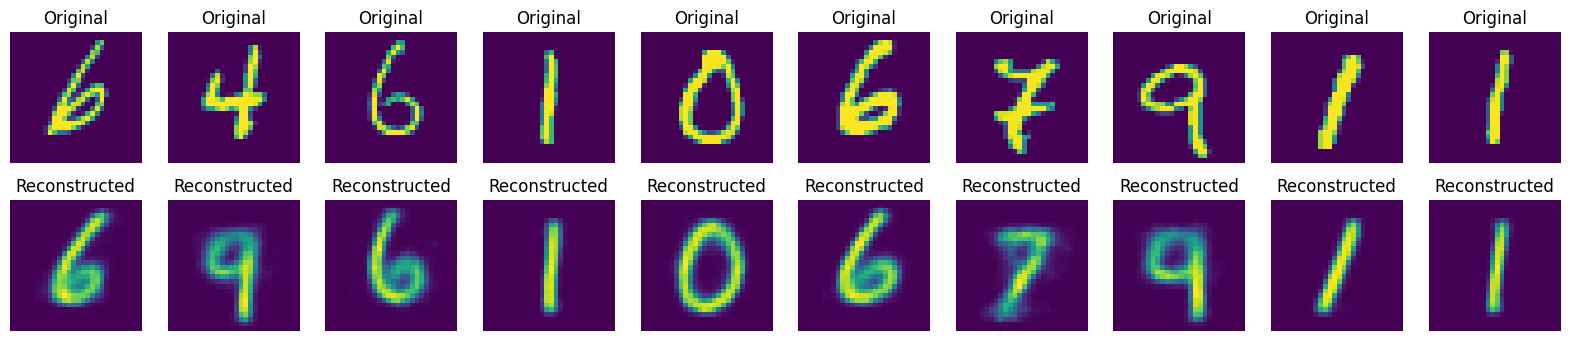

In [11]:
# Plot original and reconstructed images side by side
n = 10 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original image: (C,H,W) -> (H,W,C)
    orig = images[i].cpu().permute(1, 2, 0).numpy()
    recon = recon_images[i].cpu().permute(1, 2, 0).numpy()

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon)
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()
